
#### Mapping Stations to the NYC city map
  
As of this point, we should have a list of the most visited stations, and we want to narrow this list down so that we can focus our efforts on specific stations that will most prominently feature individuals who would be interested in a Women in Tech gala.



In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

Below, we take in csv files containing the locations of various colleges and universities, as well as subway station locations. They will be converted into dataframes where we have names, latitudes and longitudes.

In [3]:
college_df = pd.read_csv('https://data.cityofnewyork.us/api/views/8pnn-kkif/rows.csv')

college_df.head()

,the_geom,NAME,HOUSENUM,STREETNAME,CITY,ZIP,URL,BIN,BBL
0,POINT (-73.99465215457163 40.73519616365903),New School University / Parsons School Of Design,66,FIFTH AVENUE,New York,10011,http://www.parsons.edu/html/splash.html,1009619,1.006e+09
1,POINT (-73.99706966379965 40.73546280987431),New School University / The New School,66,WEST 12 STREET,New York,10011,http://www.newschool.edu/,1083136,1.006e+09
2,POINT (-74.00681944352681 40.723441859057495),Metropolitan College,75,VARICK STREET,New York,10013,http://www.metropolitan.edu/,1002934,1.002e+09
3,POINT (-73.79439300079635 40.73944287003665),School Of Nursing Of St. Vincents Catholic Med...,175-05,HORACE HARDING EXPRESSWAY,Fresh Meadows,11365,http://www.svcmc.org/portal/training/allied_he...,4148794,4.069e+09
4,POINT (-73.84872054010768 40.721371886956774),Bramson Ort College,69-30,AUSTIN STREET,Forest Hills,11375,http://www.bramsonort.org/,4077468,4.032e+09


In [4]:
college_df['the_geom'] = college_df['the_geom'].str.lstrip('POINT')
college_df['the_geom'] = college_df['the_geom'].str.strip()
college_df['the_geom'] = college_df['the_geom'].str.lstrip('(')
college_df['the_geom'] = college_df['the_geom'].str.rstrip(')')

new = college_df['the_geom'].str.split(' ', n = 1, expand=True)

college_df['Latitude'] = new[0]
college_df['Longitude'] = new[1]

college_df.drop(columns=['URL','BIN', 'BBL', 'the_geom', 'HOUSENUM','STREETNAME','CITY','ZIP'], inplace=True)
college_df.head()

,NAME,Latitude,Longitude
0,New School University / Parsons School Of Design,-73.99465215457163,40.73519616365903
1,New School University / The New School,-73.99706966379965,40.73546280987431
2,Metropolitan College,-74.00681944352681,40.723441859057495
3,School Of Nursing Of St. Vincents Catholic Med...,-73.79439300079635,40.73944287003665
4,Bramson Ort College,-73.84872054010768,40.721371886956774


In [5]:
station_df = pd.read_csv('https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv')

In [6]:
station_df['the_geom'] = station_df['the_geom'].str.lstrip('POINT')
station_df['the_geom'] = station_df['the_geom'].str.strip()
station_df['the_geom'] = station_df['the_geom'].str.lstrip('(')
station_df['the_geom'] = station_df['the_geom'].str.rstrip(')')

new = station_df['the_geom'].str.split(' ', n = 1, expand=True)

station_df['Latitude'] = new[0]
station_df['Longitude'] = new[1]

station_df.drop(columns=['URL','NOTES', 'OBJECTID', 'the_geom'], inplace=True)
station_df.head()

,NAME,LINE,Latitude,Longitude
0,Astor Pl,4-6-6 Express,-73.99106999861966,40.73005400028978
1,Canal St,4-6-6 Express,-74.00019299927328,40.71880300107709
2,50th St,1-2,-73.98384899986625,40.76172799961419
3,Bergen St,2-3-4,-73.97499915116808,40.68086213682956
4,Pennsylvania Ave,3-4,-73.89488591154061,40.66471445143568


In [7]:
# Need to convert to floats in order to work with them in geopandas
college_df['Latitude'] = college_df['Latitude'].astype(float)
college_df['Longitude'] = college_df['Longitude'].astype(float)

station_df['Latitude'] = station_df['Latitude'].astype(float)
station_df['Longitude'] = station_df['Longitude'].astype(float)

At this point, we have a dataframe containing colleges and their locations in Latitude and Longitude, and a similar dataframe for stations and their locations. Now we're going to pull in the top 25 stations that we determined previously and put together a dataframe with their locations.

In [12]:
# top25_df = pd.read_csv('/home/danish/ds/metis/github/project01/project1/data/top_25.csv')

# top25_df.rename(columns = {'STATION': 'NAME'}, inplace=True)

,NAME,LINE,Latitude,Longitude
0,Astor Pl,4-6-6 Express,-73.991,40.730
1,Canal St,4-6-6 Express,-74.000,40.719
2,50th St,1-2,-73.984,40.762
3,Bergen St,2-3-4,-73.975,40.681
4,Pennsylvania Ave,3-4,-73.895,40.665
...,...,...,...,...
468,Coney Island - Stillwell Av,D-F-N-Q,-73.981,40.577
469,34th St - Hudson Yards,7-7 Express,-74.002,40.755
470,72nd St,Q,-73.958,40.769
471,86th St,Q,-73.952,40.778


Now that we have latitude and longitude data for both sets, we are going to import a street map and utilize geopandas to plot it.

In [7]:
#Utilizing geopandas built-in NYC borough map as an underlay
streetmap = gpd.read_file(gpd.datasets.get_path('nybb'))
streetmap = streetmap.to_crs(epsg=4326)

We need to convert our latitudes and longitudes into usable points, and we need to specify a coordinate reference system (in this case the latitude/longitude projection system)

In [18]:
geometry_stations = [Point(xy) for xy in zip(station_df['Latitude'], station_df['Longitude'])]
geometry_colleges = [Point(xy) for xy in zip(college_df['Latitude'], college_df['Longitude'])]
crs = {'init': 'epsg:4326'}

In [19]:
college_geo_df = gpd.GeoDataFrame(college_df, crs=crs, geometry=geometry_colleges)
college_geo_df.head()

,NAME,Latitude,Longitude,geometry
0,New School University / Parsons School Of Design,-73.995,40.735,POINT (-73.99465215457163 40.73519616365903)
1,New School University / The New School,-73.997,40.735,POINT (-73.99706966379965 40.73546280987431)
2,Metropolitan College,-74.007,40.723,POINT (-74.00681944352681 40.72344185905749)
3,School Of Nursing Of St. Vincents Catholic Med...,-73.794,40.739,POINT (-73.79439300079635 40.73944287003665)
4,Bramson Ort College,-73.849,40.721,POINT (-73.84872054010768 40.72137188695677)


In [20]:
station_geo_df = gpd.GeoDataFrame(station_df, crs=crs, geometry=geometry_stations)
station_geo_df.head()

,NAME,LINE,Latitude,Longitude,geometry
0,Astor Pl,4-6-6 Express,-73.991,40.730,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,4-6-6 Express,-74.000,40.719,POINT (-74.00019299927328 40.71880300107709)
2,50th St,1-2,-73.984,40.762,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,2-3-4,-73.975,40.681,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,3-4,-73.895,40.665,POINT (-73.89488591154061 40.66471445143568)


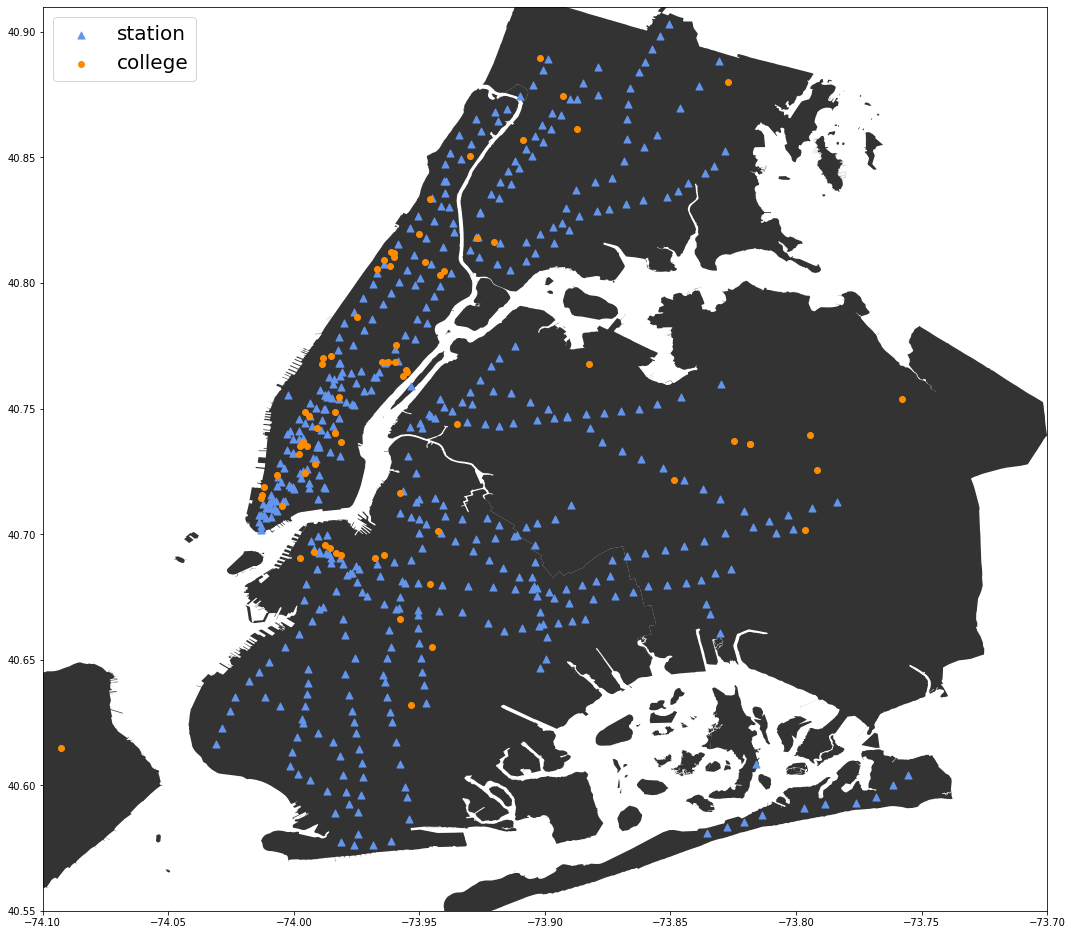

In [21]:
fig, ax = plt.pyplot.subplots(figsize=(18,18))
# minx, miny, maxx, maxy = geo_df.total_bounds

#Limiting borders in order to get a zoomed in image
ax.set_xlim(-74.1, -73.7)
ax.set_ylim(40.55, 40.91)

# ax = streetmap.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
streetmap.plot(ax=ax, alpha= 0.8, color='black');
station_geo_df.plot(ax=ax,color='#6495ED', markersize=50, marker='^', label='station');
college_geo_df.plot(ax=ax,color='#FF8C00', marker='o', label='college');
plt.pyplot.legend(loc='upper left', prop={'size': 20});
plt.pyplot.savefig('college station overlay.svg')